In [1]:
import numpy as np
mutated_data = np.load("/content/MUTATION_DATA_TRAINING_6000.npz", allow_pickle=True)
mutated_test = mutated_data['arr_0'][:1000]
output_test = "MUTATED_DATA_TEST_1000_6000"
np.savez_compressed(output_test, arr_0=np.array(mutated_test))
mutated_val = mutated_data['arr_0'][5000:]
output_val = "MUTATED_DATA_VAL_1000_6000"
np.savez_compressed(output_val, arr_0=np.array(mutated_val))
mutated_train = mutated_data['arr_0'][1000:5000]
output_train = "MUTATED_DATA_TRAIN_5000_6000"
np.savez_compressed(output_train, arr_0=np.array(mutated_train))



In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras import regularizers
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to load sequences (unchanged)
def load_sequences(data):
    encoded_sequences = None
    for key in data.files:
        temp_sequences = data[key]
        if temp_sequences.ndim == 2:
            num_samples = temp_sequences.shape[0]
            sequence_length = temp_sequences.shape[1] // 4
            temp_sequences = np.expand_dims(temp_sequences, axis=1)
        if temp_sequences.ndim == 3:
            encoded_sequences = temp_sequences
            break
    return encoded_sequences

def load_sequences_with_shape(data):
    encoded_sequences = None
    for key in data.files:
        temp_sequences = data[key]
        if temp_sequences.ndim == 2:  # If 2D, reshape to 3D for LSTM
            temp_sequences = np.expand_dims(temp_sequences, axis=1)  # (samples, 1, features)
        if temp_sequences.ndim == 3:
            encoded_sequences = temp_sequences
            input_shape = input_shape=(encoded_sequences.shape[1], encoded_sequences.shape[2])
            break
    return encoded_sequences, input_shape

# Loading the data (unchanged)
mutated_data = np.load("/content/MUTATION_DATA_TRAINING_TRUE.npz", allow_pickle=True)
nonmutated_data = np.load("/content/AUGMENTED_DATA_TRAINING_6000_TRUE_1.npz", allow_pickle=True)

mutated_sequences, shape = load_sequences_with_shape(mutated_data)
nonmutated_sequences, shape = load_sequences_with_shape(nonmutated_data)

# Further loading of test, validation, and train data (unchanged)
mutated_test_1 = np.load("/content/MUTATED_DATA_TEST_1000_6000_TRUE_1.npz", allow_pickle=True)
mutated_test = load_sequences(mutated_test_1)
mutated_test_label = np.ones(mutated_test.shape[0])
mutated_test, mutated_test_label = shuffle(mutated_test, mutated_test_label, random_state=42)

mutated_val_1 = np.load("/content/MUTATED_DATA_VAL_1000_6000_TRUE_1.npz", allow_pickle=True)
mutated_val = load_sequences(mutated_val_1)
mutated_val_label = np.ones(mutated_val.shape[0])
mutated_val, mutated_val_label = shuffle(mutated_val, mutated_val_label, random_state=42)

mutated_train_1 = np.load("/content/MUTATED_DATA_TRAIN_5000_6000_TRUE_1.npz", allow_pickle=True)
mutated_train = load_sequences(mutated_train_1)
mutated_train_label = np.ones(mutated_train.shape[0])
mutated_train, mutated_train_label = shuffle(mutated_train, mutated_train_label, random_state=42)

nonmutated_test_1 = np.load("/content/AUGMENTED_DATA_TEST_1000_6000_TRUE.npz", allow_pickle=True)
nonmutated_test = load_sequences(nonmutated_test_1)
nonmutated_test_label = np.zeros(nonmutated_test.shape[0])
nonmutated_test, nonmutated_test_label = shuffle(nonmutated_test, nonmutated_test_label, random_state=42)

nonmutated_val_1 = np.load("/content/AUGMENTED_DATA_TEST_VAL_1000_6000_TRUE.npz", allow_pickle=True)
nonmutated_val = load_sequences(nonmutated_val_1)
nonmutated_val_label = np.zeros(nonmutated_val.shape[0])
nonmutated_val, nonmutated_val_label = shuffle(nonmutated_val, nonmutated_val_label, random_state=42)

nonmutated_train_1 = np.load("/content/AUGMENTED_DATA_TRAIN_5000_6000_TRUE.npz", allow_pickle=True)
nonmutated_train = load_sequences(nonmutated_train_1)
nonmutated_train_label = np.zeros(nonmutated_train.shape[0])
nonmutated_train, nonmutated_train_label = shuffle(nonmutated_train, nonmutated_train_label, random_state=42)

# Combine the mutated and nonmutated data for training, validation, and testing (unchanged)
X_val = np.concatenate([mutated_val, nonmutated_val], axis=0)
y_val = np.concatenate([mutated_val_label, nonmutated_val_label], axis=0)
X_val, y_val = shuffle(X_val, y_val, random_state=1)

X_test = np.concatenate([mutated_test, nonmutated_test], axis=0)
y_test = np.concatenate([mutated_test_label, nonmutated_test_label], axis=0)
X_test, y_test = shuffle(X_test, y_test, random_state=1)

X_train = np.concatenate([mutated_train, nonmutated_train], axis=0)
y_train = np.concatenate([mutated_train_label, nonmutated_train_label], axis=0)
X_train, y_train = shuffle(X_train, y_train, random_state=1)

# Now applying PCA to the training, validation, and test data
def apply_pca(X_train, X_val, X_test, n_components=100):
    # Flatten each sequence to a 2D array (samples, sequence_length * 4)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_val_scaled = scaler.transform(X_val_flat)
    X_test_scaled = scaler.transform(X_test_flat)

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, X_val_pca, X_test_pca

# Apply PCA with the desired number of components (e.g., 100 components)
X_train_pca, X_val_pca, X_test_pca = apply_pca(X_train, X_val, X_test, n_components=100)

# You can now use X_train_pca, X_val_pca, and X_test_pca for model training


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print to verify
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0, 1: 1.0}


In [15]:
import seaborn as sns
flat_control_data = nonmutated_val.flatten()
flat_mutated_data = mutated_val.flatten()

# Plotting histograms for comparison
plt.figure(figsize=(12, 6))

# Plot histogram for control data
plt.subplot(1, 2, 1)
sns.histplot(flat_control_data, bins=50, kde=True, color="blue")
plt.title("Control Data (Non-mutated)")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

# Plot histogram for mutated data
plt.subplot(1, 2, 2)
sns.histplot(flat_mutated_data, bins=50, kde=True, color="red")
plt.title("Mutated Data")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow import keras
def rnn_model(input_shape):
    model = Sequential([

        # First LSTM Layer
        LSTM(64, input_shape=input_shape, return_sequences=True, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),    # Reduced L2 regularization strength
        LSTM(32, activation="relu", return_sequences=True),
        Dropout(0.2),
        # Second LSTM Layer
        LSTM(16, activation="relu", return_sequences=False),  # Reduced L2 regularization strength



        Dense(4, activation="relu"),
        Dropout(0.4),        # Output Layer
        Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.L2(0.005))  # Output layer with L2
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
    return model
def reset_rnn(input_shape):
    # Recreate the model to reset weights
    model = rnn_model(input_shape)
    return model

# Train the model
checkpoint_path = "E:/my_models/6000_3_if_new_best_model.weights.h5"
shape = input_shape=(X_train_pca.shape[1], 1)
model1 = reset_rnn(shape)

In [ ]:

checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)
csv_logger = CSVLogger("training_log_6000_3.csv")

history = model1.fit(X_train_pca, y_train, validation_data=(X_val_pca, y_val),
                    epochs=10, batch_size=32, callbacks=[checkpoint, csv_logger])


# Evaluate the model
y_pred = model1.predict(X_test)
print(y_pred)
y_pred_classes = (y_pred > 0.5).astype("int32")
report = classification_report(y_test, y_pred_classes)
report_df = pd.DataFrame(report).transpose()

# Save the report to a CSV file
report_df.to_csv("6000_new_if_classification_report.csv")
# Evaluate model performance
print(report)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.5f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Test Accuracy
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model1.predict(X_test).flatten()
print("\n🔹 First 10 Predictions vs Actual Values 🔹")
for i in range(10):
    print(f"Sample {i+1}: Actual = {y_test[i]}, Predicted Probability = {predictions[i]:.4f}")

Epoch 1/10


In [63]:
model1.summary()

# Check regularizers applied to each layer:
for layer in model1.layers:
    if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None:
        print(f"Layer {layer.name} has regularizer: {layer.kernel_regularizer}")


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_112 (LSTM)                      │ (None, 100, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 100, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_113 (LSTM)                      │ (None, 100, 32)             │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_114 (LSTM)                      │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,777 (128.04 KB)

 Trainable params: 32,649 (127.54 KB)

 Non-trainable params: 128 (512.00 B)

Layer dense_75 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x7efffc2fd870>


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9622 - loss: 0.4456
Test Accuracy: 0.9690
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1000
         1.0       1.00      0.94      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

ROC-AUC: 1.0


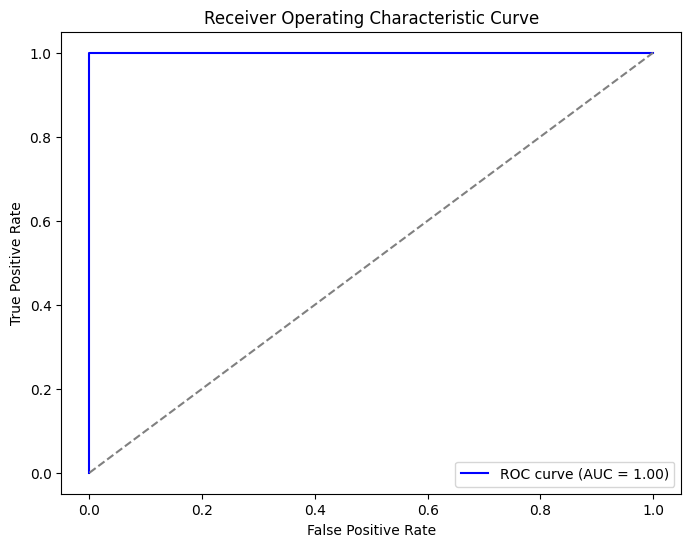

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9622 - loss: 0.4456
Test Accuracy: 0.9690
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step

🔹 First 10 Predictions vs Actual Values 🔹
Sample 1: Actual = 1.0, Predicted Probability = 0.9966
Sample 2: Actual = 0.0, Predicted Probability = 0.0000
Sample 3: Actual = 0.0, Predicted Probability = 0.0000
Sample 4: Actual = 0.0, Predicted Probability = 0.0000
Sample 5: Actual = 0.0, Predicted Probability = 0.0000
Sample 6: Actual = 0.0, Predicted Probability = 0.0000
Sample 7: Actual = 1.0, Predicted Probability = 0.9966
Sample 8: Actual = 1.0, Predicted Probability = 0.9966
Sample 9: Actual = 0.0, Predicted Probability = 0.0000
Sample 10: Actual = 1.0, Predicted Probability = 0.9986


In [13]:
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
y_pred = model1.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Evaluate model performance
print(classification_report(y_test, y_pred_classes))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Test Accuracy
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model1.predict(X_test).flatten()
print("\n🔹 First 10 Predictions vs Actual Values 🔹")
for i in range(10):
    print(f"Sample {i+1}: Actual = {y_test[i]}, Predicted Probability = {predictions[i]:.4f}")

In [ ]:
import shap
explainer = shap.Explainer(model, X_train)
explainer = shap.GradientExplainer(model, X_train_combined[:100])
# Calculate SHAP values for the input data
shap_values = explainer(X_train)






KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, input_data)

In [ ]:
shap.initjs()  # Initialize JavaScript visualization
shap.force_plot(shap_values[0], input_data[0]

In [ ]:
shap.dependence_plot("feature_name", shap_values, input_data)

In [ ]:
shap.waterfall_plot(shap_values[0])